In [3]:
import numpy as np
import pandas as pd
import mygene
import omnipath as op
import matplotlib.pyplot as plt
import seaborn as sns
import mellon as ml
import random
import networkx as nx
from pyensembl import EnsemblRelease

In [4]:
# import gtex expression data

gtex_link = 'raw_data/GTEx_tissue_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
exp = pd.read_csv(gtex_link, sep='\t', index_col='Description', skiprows=2)
exp_cns = exp

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]

In [5]:
mg = mygene.MyGeneInfo()
ensembl_gtex = list(np.unique(pd.DataFrame(list(exp_cns.index.str.split('.')))[0]))

# specify the release number
ensembl = EnsemblRelease(109)
genes = ensembl.genes()

# create a DataFrame of gene information
ensembl_ann = pd.DataFrame({
    'gene_id': [gene.gene_id for gene in genes],
    'gene_name': [gene.gene_name for gene in genes],
    'chromosome': [gene.contig for gene in genes],
    'type': [gene.biotype for gene in genes]
})
gtex_annotated = ensembl_ann[ensembl_ann['gene_name'].isin(ensembl_gtex)]
protein = gtex_annotated[gtex_annotated['type']=='protein_coding']['gene_name']

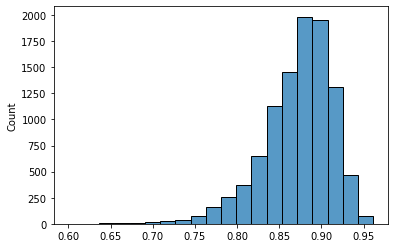

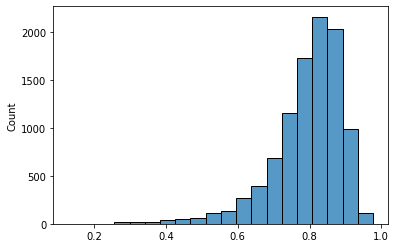

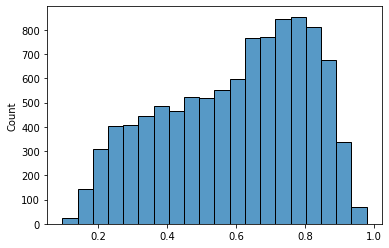

In [6]:

reslist = [0.40, 0.55, 0.70]
iter = 10000
genes = pd.read_csv('processed_data/00-hot_one_encode_disease_genes/hot-encoded-diseases_0.400000.csv')['genes']
universe = list(set(protein).difference(set(list(genes)).intersection(set(protein))))

for res in range(0,len(reslist)):
    if (reslist[res]!=0.55):
        genes = pd.read_csv('processed_data/00-hot_one_encode_disease_genes/hot-encoded-diseases_%s00000.csv' % reslist[res])
    if (reslist[res]==0.55):
        genes = pd.read_csv('processed_data/00-hot_one_encode_disease_genes/hot-encoded-diseases_%s0000.csv' % reslist[res])
    boot = []
    for i in range (0,iter):
            rand = random.sample(range(0,len(universe)), np.shape(genes)[0])
            brainSubset = pd.DataFrame(universe).iloc[rand]
            LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(brainSubset[0]))) | (db['genesymbol_intercell_target'].isin(list(brainSubset[0])))]
            LRs = LRs.dropna()
            unique_genes = list(pd.concat([LRs['genesymbol_intercell_source'],LRs['genesymbol_intercell_target']], axis = 0).unique())
            adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)
            for n in range (0, np.shape(LRs)[0]):
                adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1
            # Create network and detect communities
            if (len(adj_LRs)<1):
                print('No LRs in list')
            else:
                H = nx.from_pandas_adjacency(adj_LRs)
                comms = ml.network.louvain_communities(H, seed = 123, resolution = 0.01)

                # Check which is the largest network and save % of total LRs in network
                for l in range(0,len(comms)):
                    this = len(comms[l])
                    
                    if (l == 0):
                        longest = this
                        cluster = comms[l]
                    elif (this > longest):
                        longest = this
                        cluster = comms[l]
                    
                boot.append(longest/len(H))
                del adj_LRs
                del LRs

    sns.histplot(data = boot, bins = 20)
    plt.savefig('plots/03-LR_network_visualisation/03d_network_stats_per_threshold/hist_distribution_%s.png' % reslist[res], dpi=150)
    plt.show()

    if (res==0):
        results = pd.DataFrame(boot, columns = [reslist[res]])
    else: 
       results = pd.concat([results, pd.DataFrame(boot, columns = [reslist[res]])], axis = 1)

results.to_csv('processed_data/03-LR_network_visualisation/03d_network_stats_per_threshold/bootstrapped_results_10000iter_%majornetwork.csv')
            
#

In [7]:
occurance = pd.read_csv('processed_data/03-LR_network_visualisation/03l_visualise_networks/%_genes_in_major_network.csv')



In [8]:
(results[0.40]>occurance['0.400000'][0]).sum()/iter

0.0

In [9]:
(results[0.55]>occurance['0.550000'][0]).sum()/iter

0.0032

In [10]:
(results[0.7]>occurance['0.700000'][0]).sum()/iter

0.4592

In [11]:
occurance

,Unnamed: 0,0.100000,0.150000,0.200000,0.250000,0.300000,0.350000,0.400000,0.450000,0.500000,0.550000,0.600000,0.650000,0.700000
0,0,0.958796,0.964551,0.960447,0.958067,0.955296,0.961661,0.963252,0.971774,0.966049,0.948673,0.733871,0.69145,0.65641


In [12]:
results

,0.40,0.55,0.70
0,0.903458,0.867882,0.520619
1,0.890647,0.884298,0.649057
2,0.870031,0.794183,0.472393
3,0.859736,0.770574,0.570815
4,0.769231,0.840426,0.807018
...,...,...,...
9995,0.880857,0.772487,0.791519
9996,0.906494,0.826531,0.343558
9997,0.900671,0.874227,0.629268
9998,0.900709,0.770270,0.691983


In [ ]:
0